### Model Testing 
Author: Anne Tumlin

Date: 04/10/25 

Let's compare this problem across various types of models and evaluate the performance. 

In [12]:
import os
import subprocess
import time
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import col, explode, input_file_name, expr, sum as spark_sum, avg, count


spark = (
    SparkSession.builder
    .config("spark.dynamicAllocation.enabled", "false")
    .getOrCreate()
)

25/04/11 05:30:03 INFO SparkEnv: Registering MapOutputTracker
25/04/11 05:30:03 INFO SparkEnv: Registering BlockManagerMaster
25/04/11 05:30:03 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
25/04/11 05:30:03 INFO SparkEnv: Registering OutputCommitCoordinator


Here we are going to load in our saved parquet file of the final dataset we are using for the prediction task. If you do not have this saved, go to Mileston3 and run the notebook to aquire this dataset. 

*Important note: make sure to change to your bucket name here.* 

In [13]:
# Set the bucket name (user can change this line)
bucket_name = "ds5460-tumlinam-fp-bucket"

data_path = f"gs://{bucket_name}/final_datasets/combined_features_df/"

In [14]:
df = spark.read.parquet(data_path)
df.show(5)

+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+
|            filename|        total_cost|            avg_pd|       pd_per_load|     reactive_ratio|             std_pd|  load_variability|          pd_range|        load_range|            max_pd|  load_concentration|        load_skew|  generation_margin| load_to_gen_ratio|
+--------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+------------------+------------------+--------------------+-----------------+-------------------+------------------+
|gs://ds5460-tumli...| 457017.6915453811|0.6337165224374126|0.6337165224374126|0.25578066583740294| 0.3907887552662506| 0.616661774515822| 2.895855111560307| 2.895855111560307| 2

### Simple Model Comparisons 

Let's set up the code to test various simple models. 

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.functions import col
import time

In [18]:
feature_cols = [c for c in df.columns if c != "filename" and c != "total_cost"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_vector = assembler.transform(df).select("features", col("total_cost").alias("label"))

In [19]:
train_data, test_data = df_vector.randomSplit([0.8, 0.2], seed=42)

In [20]:
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")

# Models to test
models = [
    (LinearRegression(), "Linear Regression"),
    (DecisionTreeRegressor(), "Decision Tree"),
    (RandomForestRegressor(), "Random Forest"),
    (GBTRegressor(), "Gradient Boosted Trees")
]

In [21]:
def train_and_evaluate_model(regressor, name):
    start_time = time.time()
    
    # Train the model
    model = regressor.fit(train_data)
    
    # Make predictions
    predictions = model.transform(test_data)
    
    # Evaluate metrics
    rmse = evaluator.setMetricName("rmse").evaluate(predictions)
    mae = evaluator.setMetricName("mae").evaluate(predictions)
    r2 = evaluator.setMetricName("r2").evaluate(predictions)
    
    end_time = time.time()
    train_time = end_time - start_time

    return (name, rmse, mae, r2, train_time)

In [22]:
results = [train_and_evaluate_model(m, n) for m, n in models]

columns = ["Model", "RMSE", "MAE", "R2", "TrainingTime"]
results_df = spark.createDataFrame(results, columns)

results_df.show(truncate=False)

25/04/11 05:34:19 WARN Instrumentation: [413895b0] regParam is zero, which might cause numerical instability and overfitting.
25/04/11 05:34:31 WARN Instrumentation: [413895b0] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/04/11 05:34:35 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
25/04/11 05:34:35 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?


+----------------------+------------------+------------------+------------------+------------------+
|Model                 |RMSE              |MAE               |R2                |TrainingTime      |
+----------------------+------------------+------------------+------------------+------------------+
|Linear Regression     |280.7656305912491 |220.6685334183242 |0.9983248319489453|61.4363751411438  |
|Decision Tree         |499.8519540256585 |360.21251018260307|0.9946905041803394|66.4631974697113  |
|Random Forest         |543.9339953591083 |344.5596907496637 |0.9937127185766577|60.810118198394775|
|Gradient Boosted Trees|474.10795874994085|334.27393095688205|0.9952233327755488|83.85276007652283 |
+----------------------+------------------+------------------+------------------+------------------+



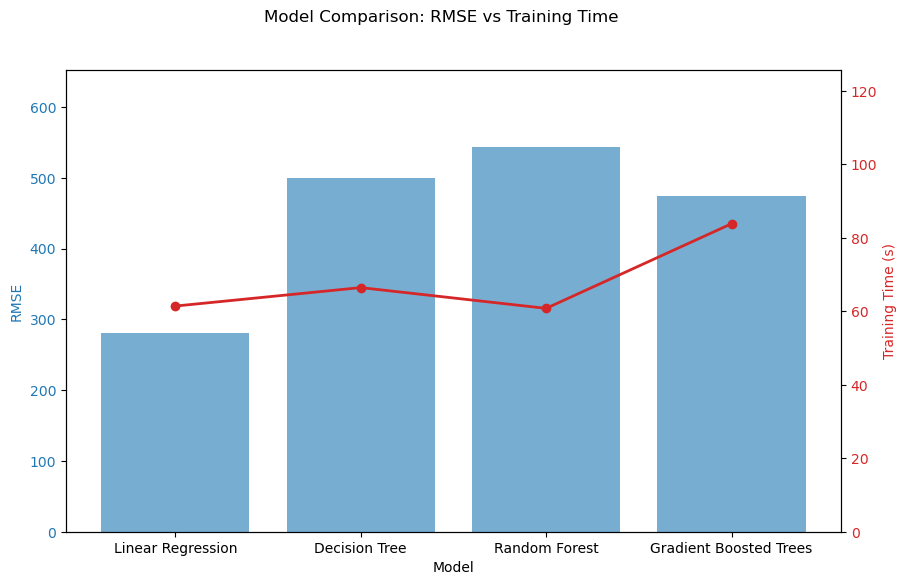

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

data = {
    "Model": [
        "Linear Regression",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosted Trees"
    ],
    "RMSE": [
        280.7656305912491,
        499.8519540256585,
        543.9339953591083,
        474.10795874994085
    ],
    "MAE": [
        220.6685334183242,
        360.21251018260307,
        344.5596907496637,
        334.27393095688205
    ],
    "R2": [
        0.9983248319489453,
        0.9946905041803394,
        0.9937127185766577,
        0.9952233327755488
    ],
    "TrainingTime": [
        61.4363751411438,
        66.4631974697113,
        60.810118198394775,
        83.85276007652283
    ]
}

df_plot = pd.DataFrame(data)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for RMSE
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color=color)
ax1.bar(df_plot["Model"], df_plot["RMSE"], color=color, alpha=0.6, label="RMSE")
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, max(df_plot["RMSE"]) * 1.2)

# Line plot for Training Time on second y-axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(df_plot["Model"], df_plot["TrainingTime"], color=color, marker='o', linewidth=2, label="Training Time")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, max(df_plot["TrainingTime"]) * 1.5)

# Title and layout
fig.suptitle("Model Comparison: RMSE vs Training Time")
plt.show()


### More Complex Models 

Now that we have our results for the simple models, let's see what we can do to improve results. Let's try to implement XGBoost.

In [5]:
!pip install xgboost==1.7.6

In [25]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost.spark import SparkXGBRegressor
import time

In [15]:
feature_cols = [c for c in df.columns if c != "filename" and c != "total_cost"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembled_df = assembler.transform(df).select("features", col("total_cost").alias("label"))

train_data, test_data = assembled_df.randomSplit([0.8, 0.2], seed=42)

In [16]:
xgb = SparkXGBRegressor(
    objective='reg:squarederror',
    num_round=50,
    max_depth=6,
    eta=0.1,
    features_col="features",
    label_col="label",
    prediction_col="prediction"
)

start_time = time.time()
xgb_model = xgb.fit(train_data)
train_time = time.time() - start_time

print(f"XGBoost training completed in {train_time:.2f} seconds.")

XGBoost training completed in 29.25 seconds.


/opt/conda/miniconda3/lib/python3.10/site-packages/xgboost/sklearn.py:782: UserWarning: Loading a native XGBoost model with Scikit-Learn interface.
  warnings.warn("Loading a native XGBoost model with Scikit-Learn interface.")


In [17]:
from pyspark.ml.evaluation import RegressionEvaluator

predictions = xgb_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")

RMSE: 332.0242
MAE:  230.4305
R²:   0.9977


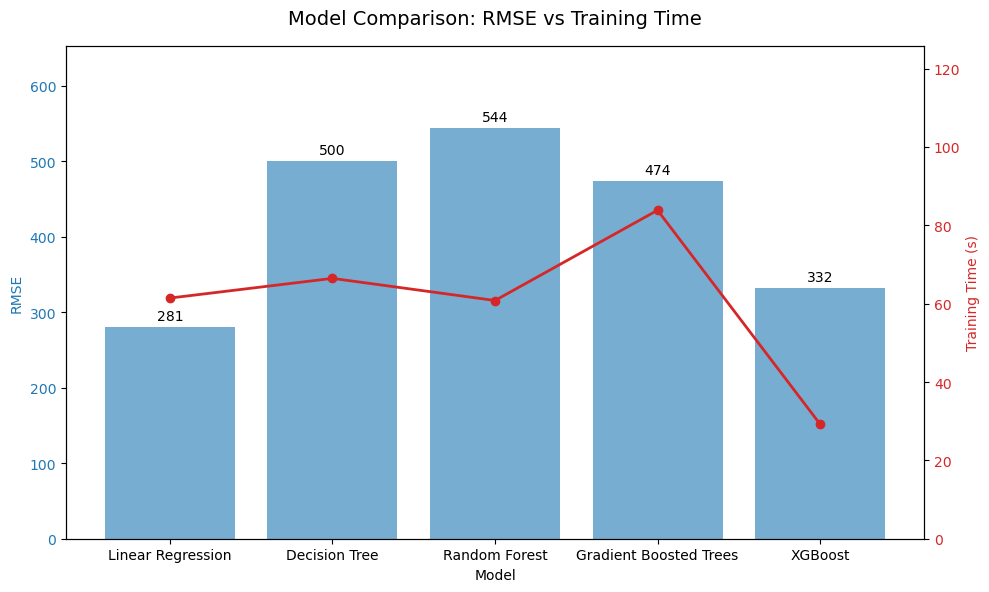

In [24]:
import matplotlib.pyplot as plt
import pandas as pd

# Final results with XGBoost
data = {
    "Model": [
        "Linear Regression",
        "Decision Tree",
        "Random Forest",
        "Gradient Boosted Trees",
        "XGBoost"
    ],
    "RMSE": [
        280.7656305912491,
        499.8519540256585,
        543.9339953591083,
        474.10795874994085,
        332.0242
    ],
    "MAE": [
        220.6685334183242,
        360.21251018260307,
        344.5596907496637,
        334.27393095688205,
        230.4305
    ],
    "R2": [
        0.9983248319489453,
        0.9946905041803394,
        0.9937127185766577,
        0.9952233327755488,
        0.9977
    ],
    "TrainingTime": [
        61.4363751411438,
        66.4631974697113,
        60.810118198394775,
        83.85276007652283,
        29.25
    ]
}

df_plot = pd.DataFrame(data)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for RMSE
color = 'tab:blue'
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE', color=color)
bars = ax1.bar(df_plot["Model"], df_plot["RMSE"], color=color, alpha=0.6)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, max(df_plot["RMSE"]) * 1.2)

# Annotate RMSE values
for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.0f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

# Line plot for training time
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Training Time (s)', color=color)
ax2.plot(df_plot["Model"], df_plot["TrainingTime"], color=color, marker='o', linewidth=2)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, max(df_plot["TrainingTime"]) * 1.5)

# Title and formatting
fig.suptitle("Model Comparison: RMSE vs Training Time", fontsize=14)
plt.tight_layout()
plt.show()

### Tuning XGBoost

In [34]:
xgb = SparkXGBRegressor(
    num_workers=2,
    objective='reg:squarederror',
    eval_metric='rmse',
    tree_method='hist'
)

paramGrid = (ParamGridBuilder()
    .addGrid(xgb.max_depth, [4, 5, 6])
    .addGrid(xgb.learning_rate, [0.04, 0.05, 0.06])
    .addGrid(xgb.n_estimators, [150, 200, 250])
    .addGrid(xgb.subsample, [0.8, 1.0])
    .addGrid(xgb.colsample_bytree, [0.8, 1.0])
    .build())

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")

tvs = TrainValidationSplit(estimator=xgb,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8,
                           parallelism=2)

In [35]:
start_time = time.time()
xgb_model_tuned = tvs.fit(train_data)
train_time = time.time() - start_time

predictions = xgb_model_tuned.transform(test_data)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")
print(f"Training Time: {train_time:.2f} seconds")

RMSE: 336.3870
MAE:  224.8225
R²:   0.9976
Training Time: 629.34 seconds


In [36]:
best_model = xgb_model_tuned.bestModel

# Print the best parameter values
print("Best max_depth:", best_model.getOrDefault("max_depth"))
print("Best learning_rate:", best_model.getOrDefault("learning_rate"))
print("Best n_estimators:", best_model.getOrDefault("n_estimators"))

Best max_depth: 5
Best learning_rate: 0.04
Best n_estimators: 250


Even after tuning, XGBoost is not performing better than Linear Regression. If the mapping from features to total_cost is close to linear, then a linear regression model might actually be ideal. More complex models like XGBoost add unnecessary complexity, which can lead to slightly overfitting and requires more tuning to match linear performance. 

### Investigate Linear Regression

In [37]:
# Is total cost skewed? 

from pyspark.sql.functions import skewness

df.select("total_cost").describe().show()

df.select(skewness("total_cost")).show()

+-------+------------------+
|summary|        total_cost|
+-------+------------------+
|  count|             15000|
|   mean| 455058.1915002696|
| stddev|   6803.2426683212|
|    min|431924.47773403546|
|    max|483044.36281320325|
+-------+------------------+



+--------------------+
|skewness(total_cost)|
+--------------------+
| 0.10996812736741823|
+--------------------+



In [38]:
from pyspark.ml.feature import StandardScaler

assembler = VectorAssembler(inputCols=feature_cols, outputCol="raw_features")
assembled_df = assembler.transform(df).select("raw_features", col("total_cost").alias("label"))

# Let's try scaling the features
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df).select("features", "label")

train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
models = [(LinearRegression(), "Linear Regression")]

results = [train_and_evaluate_model(m, n) for m, n in models]

columns = ["Model", "RMSE", "MAE", "R2", "TrainingTime"]
results_df = spark.createDataFrame(results, columns)

results_df.show(truncate=False)

25/04/11 06:12:08 WARN Instrumentation: [39decb2e] regParam is zero, which might cause numerical instability and overfitting.
25/04/11 06:12:17 WARN Instrumentation: [39decb2e] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.
25/04/11 06:12:17 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search zoom failed
25/04/11 06:12:17 ERROR LBFGS: Failure again! Giving up and returning. Maybe the objective is just poorly behaved?
